In [1]:
import os
import json
import glob
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
if not os.path.exists('figs'): os.mkdir("figs")

plt.rcParams["font.family"] = "Times New Roman"
pd.options.display.float_format = '{:,.4f}'.format

plt.rc('legend',fontsize=32)
plt.rc('axes', labelsize=32) 

In [2]:

def get_results(model_name, context=""):
    if context:
        iter_files =glob.glob("results/{}/{}/results_checkpoint_{}_{}_iter_*.json".format(model_name, context, model_name, context))
    else:
        iter_files = glob.glob("results/{}/results_checkpoint_{}__iter_*.json".format(model_name, model_name))
    assert len(iter_files) == 10
    iters_results_df = []
    for iter_file in iter_files:
        with open(iter_file) as iter_f:
            iter_file_json = json.load(iter_f)
            context_keys = sorted(list(dict(iter_file_json).keys()))
            results_dict = dict()
            for key in context_keys:
                results_dict[key] = iter_file_json[key]["AUC"] 
            results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=[model_name])
            iters_results_df.append(results_df)
    return pd.concat(iters_results_df).groupby(level=0).mean()

In [3]:

def get_results_print(model_name, context="", n=10):
    if context:
        iter_files =glob.glob("results/{}/{}/results_checkpoint_{}_{}_iter_*.json".format(model_name, context, model_name, context))
    else:
        iter_files = glob.glob("results/{}/results_checkpoint_{}__iter_*.json".format(model_name, model_name))
    assert len(iter_files) == n
    iters_results_df = []
    for iter_file in iter_files:
        with open(iter_file) as iter_f:
            iter_file_json = json.load(iter_f)
            context_keys = sorted(list(dict(iter_file_json).keys()))
            results_dict = dict()
            for key in context_keys:
                results_dict[key] = iter_file_json[key]["AUC"] 
            results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=[model_name])
            iters_results_df.append(results_df)
    mean =  pd.concat(iters_results_df).groupby(level=0).mean()
    se = pd.concat(iters_results_df).groupby(level=0).sem()
    ci = st.t.interval(alpha=0.95, df=n-1, loc=mean, scale=se)
    ci_either = (mean- ci[0])[model_name].apply(lambda x: "{:.3f}".format(x))
    mean  = mean[model_name].apply(lambda x: "{:.3f}".format(x))
    return pd.DataFrame(mean+"±"+ci_either)

In [4]:
model_names = [
               'AE_all', 
               'AE_FiLM_one_hot',
               'AE_FiLM_embed_32',
               'AE_FiLM_embed_64',
               'AE_FiLM_embed_128',
               'AE_FiLM_embed_256'
            ]
results_list = []
for model_name in model_names:
    results_list.append(get_results(model_name))

single_model_list = []
for i in [0, 1, 2]:
    single_model_list.append(get_results("AE", context=str(i)))

single_model_results = pd.concat(single_model_list)

results_df = pd.concat([single_model_results]+results_list, axis=1)
results_df


,AE,AE_all,AE_FiLM_one_hot,AE_FiLM_embed_32,AE_FiLM_embed_64,AE_FiLM_embed_128,AE_FiLM_embed_256
0,0.9446,0.6087,0.9212,0.8596,0.8648,0.8692,0.9260
1,0.9444,0.4913,0.9161,0.7881,0.8021,0.8248,0.8298
2,0.9350,0.5181,0.8934,0.8041,0.7871,0.8159,0.8741


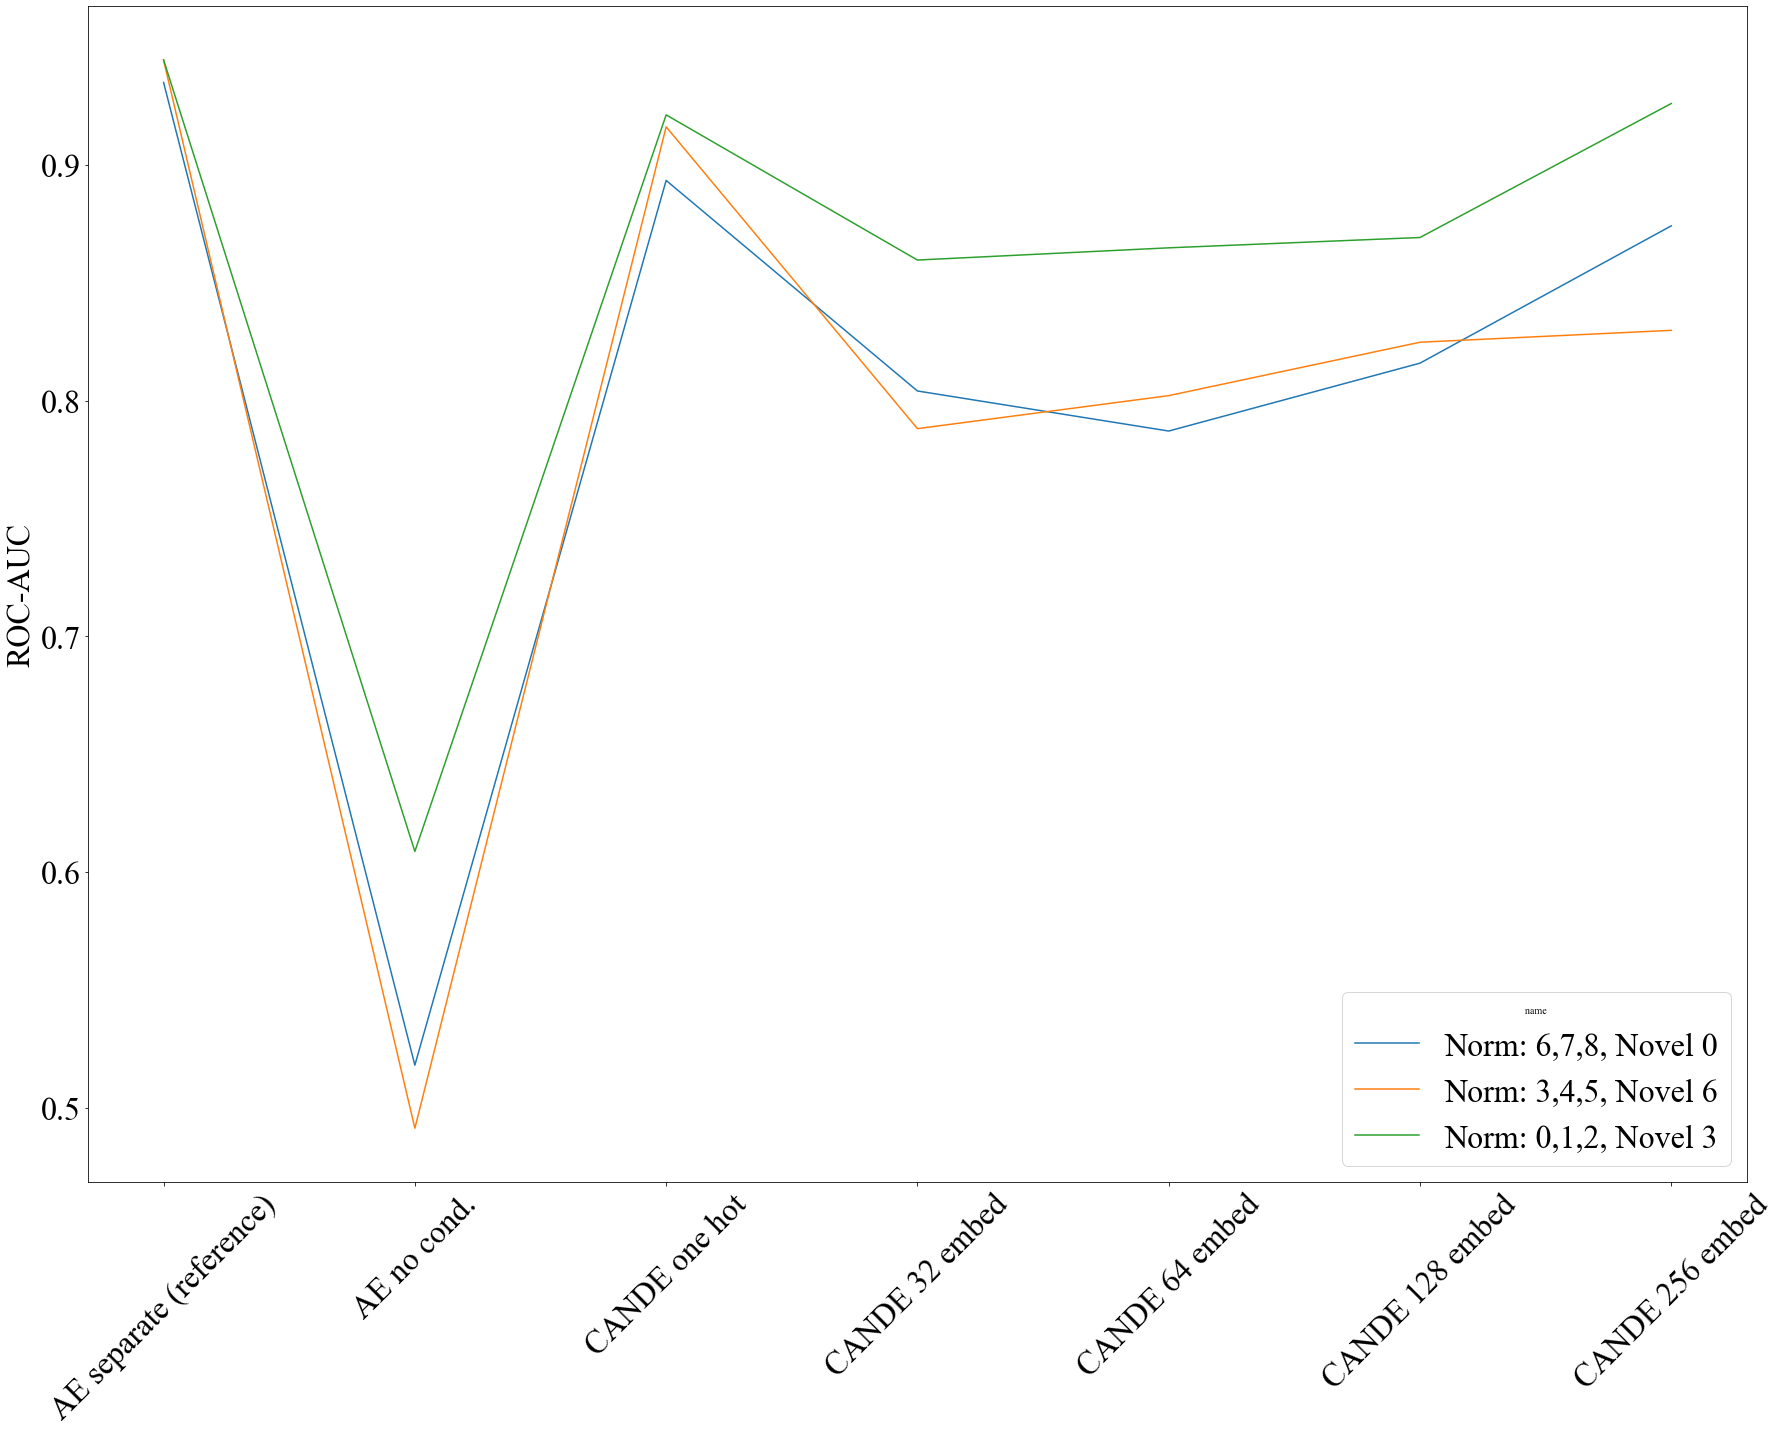

In [5]:
formatted_col_map= {
           "AE": "AE separate (reference)",
           "AE_all": "AE no cond.", 
           "AE_FiLM_one_hot"  :"CANDE one hot"  , 
           "AE_FiLM_embed_32" :"CANDE 32 embed" ,
           "AE_FiLM_embed_64" :"CANDE 64 embed" ,
           "AE_FiLM_embed_128":"CANDE 128 embed",
           "AE_FiLM_embed_256":"CANDE 256 embed"
}
context_map = {"0":"Norm: 0,1,2, Novel 3",
               "1":"Norm: 3,4,5, Novel 6", 
               "2": "Norm: 6,7,8, Novel 0"
              }
cols_to_plot = [
           "AE separate (reference)",
           "AE no cond.", 
           "CANDE one hot"  , 
           "CANDE 32 embed" ,
           "CANDE 64 embed" ,
           "CANDE 128 embed",
           "CANDE 256 embed"
]

plt_results = results_df.sort_values(by="AE")
plt_results = plt_results.rename(columns=formatted_col_map, errors="raise")
plt_results['name'] = plt_results.index.to_series().map(context_map)
plt_results = plt_results.set_index('name')

plt_results_ax = plt_results[cols_to_plot].transpose().plot(figsize=(25, 20))
plt_results_ax.tick_params(axis='both', which='major', labelsize=32)
plt_results_ax.set_ylabel("ROC-AUC")
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("figs/CANDE-MNIST-ROC-AUC.png", bbox_inches = 'tight')

In [6]:
rank_results_df = results_df[
          ["AE_all", 
           "AE_FiLM_one_hot", 
           "AE_FiLM_embed_32",
           "AE_FiLM_embed_64",
           "AE_FiLM_embed_128",
           "AE_FiLM_embed_256"
          ]
        ].rank(1, ascending=False, method='first')
mean_rank_row = rank_results_df.mean().to_frame().T
mean_rank_row = mean_rank_row.rename(index={0: 'average rank'})
results_and_ranks_df = pd.concat([results_df, mean_rank_row])
results_and_ranks_df

,AE,AE_all,AE_FiLM_one_hot,AE_FiLM_embed_32,AE_FiLM_embed_64,AE_FiLM_embed_128,AE_FiLM_embed_256
0,0.9446,0.6087,0.9212,0.8596,0.8648,0.8692,0.9260
1,0.9444,0.4913,0.9161,0.7881,0.8021,0.8248,0.8298
2,0.9350,0.5181,0.8934,0.8041,0.7871,0.8159,0.8741
average rank,nan,6.0000,1.3333,4.6667,4.3333,3.0000,1.6667


In [7]:
table_cols = [
           "AE",
           "AE_all", 
           "AE_FiLM_one_hot", 
           "AE_FiLM_embed_32",
           "AE_FiLM_embed_64",
           "AE_FiLM_embed_128",
           "AE_FiLM_embed_256"
          ]

results_table = results_and_ranks_df[table_cols]

formatted_results_table = results_table.rename(columns=formatted_col_map, errors="raise")
formatted_results_table

,AE separate (reference),AE no cond.,CANDE one hot,CANDE 32 embed,CANDE 64 embed,CANDE 128 embed,CANDE 256 embed
0,0.9446,0.6087,0.9212,0.8596,0.8648,0.8692,0.9260
1,0.9444,0.4913,0.9161,0.7881,0.8021,0.8248,0.8298
2,0.9350,0.5181,0.8934,0.8041,0.7871,0.8159,0.8741
average rank,nan,6.0000,1.3333,4.6667,4.3333,3.0000,1.6667


In [8]:
model_names = [ 
               'AE_all', 
               'AE_FiLM_one_hot',
               'AE_FiLM_embed_32',
               'AE_FiLM_embed_64',
               'AE_FiLM_embed_128',
               'AE_FiLM_embed_256'
            ]
results_list_print = []
for model_name in model_names:
    results_list_print.append(get_results_print(model_name))

single_model_list_print = []
for i in [0, 1, 2]:
    single_model_list_print.append(get_results_print("AE", context=str(i)))

single_model_results_print = pd.concat(single_model_list_print)

results_df_print = pd.concat([single_model_results_print]+results_list_print, axis=1)

results_and_ranks_df_print = pd.concat([results_df_print, mean_rank_row])
results_and_ranks_df_print


,AE,AE_all,AE_FiLM_one_hot,AE_FiLM_embed_32,AE_FiLM_embed_64,AE_FiLM_embed_128,AE_FiLM_embed_256
0,0.945±0.008,0.609±0.005,0.921±0.012,0.860±0.027,0.865±0.030,0.869±0.035,0.926±0.018
1,0.944±0.003,0.491±0.013,0.916±0.010,0.788±0.037,0.802±0.040,0.825±0.055,0.830±0.056
2,0.935±0.020,0.518±0.006,0.893±0.014,0.804±0.025,0.787±0.033,0.816±0.035,0.874±0.023
average rank,NaN,6.0000,1.3333,4.6667,4.3333,3.0000,1.6667


In [9]:
results_table_print = results_and_ranks_df_print[table_cols]
formatted_results_table_print = results_table_print.rename(columns=formatted_col_map, errors="raise")
formatted_results_table_print

,AE separate (reference),AE no cond.,CANDE one hot,CANDE 32 embed,CANDE 64 embed,CANDE 128 embed,CANDE 256 embed
0,0.945±0.008,0.609±0.005,0.921±0.012,0.860±0.027,0.865±0.030,0.869±0.035,0.926±0.018
1,0.944±0.003,0.491±0.013,0.916±0.010,0.788±0.037,0.802±0.040,0.825±0.055,0.830±0.056
2,0.935±0.020,0.518±0.006,0.893±0.014,0.804±0.025,0.787±0.033,0.816±0.035,0.874±0.023
average rank,NaN,6.0000,1.3333,4.6667,4.3333,3.0000,1.6667


In [10]:
print(formatted_results_table_print.to_latex(index=False, columns=formatted_results_table_print.columns))

\begin{tabular}{lllllll}
\toprule
AE separate (reference) &  AE no cond. & CANDE one hot & CANDE 32 embed & CANDE 64 embed & CANDE 128 embed & CANDE 256 embed \\
\midrule
            0.945±0.008 &  0.609±0.005 &   0.921±0.012 &    0.860±0.027 &    0.865±0.030 &     0.869±0.035 &     0.926±0.018 \\
            0.944±0.003 &  0.491±0.013 &   0.916±0.010 &    0.788±0.037 &    0.802±0.040 &     0.825±0.055 &     0.830±0.056 \\
            0.935±0.020 &  0.518±0.006 &   0.893±0.014 &    0.804±0.025 &    0.787±0.033 &     0.816±0.035 &     0.874±0.023 \\
                    NaN &       6.0000 &        1.3333 &         4.6667 &         4.3333 &          3.0000 &          1.6667 \\
\bottomrule
\end{tabular}

